# Imports

In [1]:
# Module imports
from __future__ import print_function
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import cv2
import os
import pickle
import numpy as np
from PIL import Image
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load Data

In [3]:
rawdata = pd.read_csv('train_data.csv')
# display the top rows
rawdata.head(10)
# get a quick description of the data, including # of rows, # of features, name of each feature, type of each feature, # of non-null values
rawdata.info()
# show a summary of the numerical attributes
rawdata.describe()

rawtargetdata = pd.read_csv('train_target.csv')
# display the top rows
rawtargetdata.head(10)
# get a quick description of the data, including # of rows, # of features, name of each feature, type of each feature, # of non-null values
rawtargetdata.info()
# show a summary of the numerical attributes
rawtargetdata.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16174 entries, 0 to 16173
Columns: 2304 entries, 146 to 81.32
dtypes: int64(2304)
memory usage: 284.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16174 entries, 0 to 16173
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   1       16174 non-null  int64
dtypes: int64(1)
memory usage: 126.5 KB


,1
count,16174.000000
mean,1.059973
std,0.741898
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


#  Preprocess Data

In [4]:
# num_pipeline = Pipeline([
#     ('std_scaler', StandardScaler()),
# ])

# data_preprocessed = num_pipeline.fit_transform(rawdata)
data_preprocessed = rawdata.to_numpy()
targets_preprocessed = rawtargetdata.to_numpy()

# Split Dataset for Training, Validation, and Testing

In [5]:
train_data, valid_data, train_target, valid_target = train_test_split(data_preprocessed, targets_preprocessed, test_size = 0.20, random_state = 42)

#print(train_data)
print(f"train_data.shape: {train_data.shape}")
print(f"train_target.shape: {train_target.shape}")
print()
print(f"valid_data.shape: {valid_data.shape}")
print(f"valid_target.shape: {valid_target.shape}")

train_data.shape: (12939, 2304)
train_target.shape: (12939, 1)

valid_data.shape: (3235, 2304)
valid_target.shape: (3235, 1)


# CustomDataset Class

In [6]:
class CustomDataset(Dataset):
    def __init__(self, train_data, train_target, transform = None, target_transform = None):
        super().__init__()
        self.transform = transform
        self.target_transform = target_transform
        self.data = []
        self.targets = []
        
        for image in train_data:
            reshaped_array = np.reshape(image, (48, 48))
            pil_image = Image.fromarray(np.uint8(reshaped_array))
            self.data.append(pil_image)
        if train_target is not None:
            for target in train_target:
                self.targets.append(target[0])
        #self.data = np.vstack(self.data).reshape(-1, 48, 48)
        #self.data = self.data.transpose((0, 1, 2))  # convert to Hight by Width by Channel
        
    def __getitem__(self, idx):
        img, target = self.data[idx], self.targets[idx]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def getitem_notarget(self, idx):
        img = self.data[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.data)

# Creating CustomDatasets from preprocessed data and targets

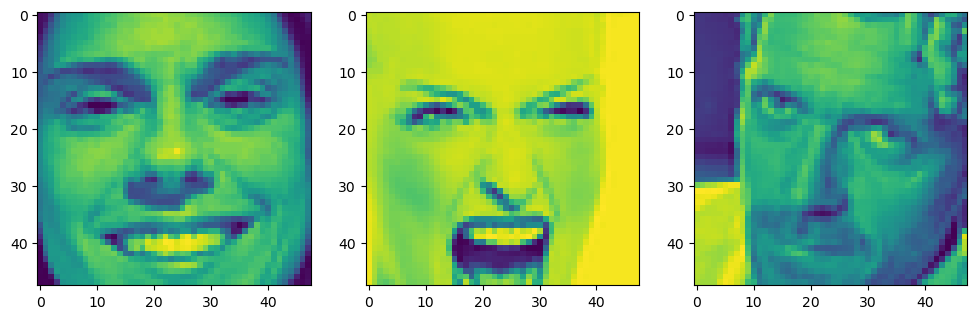

In [7]:
trainingDataset = CustomDataset(data_preprocessed, targets_preprocessed,
    transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.4915, 0.2470)
    ]))
validationDataset = CustomDataset(valid_data, valid_target,
    transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.4915, 0.2470)
    ]))

# print(trainingDataset.data[0])

images = trainingDataset.data
f, axarr = plt.subplots(1, 3, figsize=(12,12))
axarr = axarr.flatten()
#plt.axis('off')
# for i in range (0, 15):
#     axarr[i].imshow(images[i])
axarr[0].imshow(images[0])
axarr[1].imshow(images[5])
axarr[2].imshow(images[10])

# DataLoaders from CustomDataset

In [8]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available()else {}

train_loader = torch.utils.data.DataLoader(trainingDataset, batch_size=64, shuffle=True,  **kwargs)

val_loader = torch.utils.data.DataLoader(validationDataset, batch_size=64,shuffle=False, **kwargs)

In [9]:
n_out = 3

# Neural Network Model Definition

In [10]:
sequential_model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding=1),
            nn.ReLU(),
            #nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.4),
            nn.Conv2d(64, 32, kernel_size=5, padding=1),
            nn.ReLU(),
            #nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.4),
            nn.ReLU(),
            #nn.Tanh(),
            nn.Dropout2d(p=0.4),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.4),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(), 
            nn.Linear(800, n_out)
)

model = sequential_model

model.to(device)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout2d(p=0.4, inplace=False)
  (4): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout2d(p=0.4, inplace=False)
  (8): ReLU()
  (9): Dropout2d(p=0.4, inplace=False)
  (10): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Dropout2d(p=0.4, inplace=False)
  (13): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU()
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=800, out_features=3, bias=True)
)

# Training Loop

In [14]:
learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 1000
best_score = 0
#model.load_state_dict(torch.load('best-model4-paramteres.pt'))

for epoch in range(n_epochs):
    model.train(True)
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        #print(labels)
        
        outputs = model(imgs)   # important:  nn.Conv2d expects a B × C × H × W shaped tensor as input
        train_loss = loss_fn(outputs, labels)
  
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    
    model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            outputs = model(imgs)
            val_loss = loss_fn(outputs, labels)
            
            _, predicted = torch.max(outputs, dim=1)
            #print(predicted)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    val_accuracy = correct / total
    if val_accuracy > best_score:
        torch.save(model.state_dict(), 'best-model4-paramteres.pt')
        best_score = val_accuracy
    print("Epoch: %d, train_loss: %f, val_loss: %f, val_accuracy: %f, best_score: %f" % (epoch, float(train_loss), float(val_loss), val_accuracy, best_score))

Epoch: 0, train_loss: 0.336084, val_loss: 0.313151, val_accuracy: 0.834003, best_score: 0.834003
Epoch: 1, train_loss: 0.521079, val_loss: 0.317743, val_accuracy: 0.841113, best_score: 0.841113
Epoch: 2, train_loss: 0.365991, val_loss: 0.325827, val_accuracy: 0.839876, best_score: 0.841113
Epoch: 3, train_loss: 0.667663, val_loss: 0.304463, val_accuracy: 0.841113, best_score: 0.841113
Epoch: 4, train_loss: 0.610676, val_loss: 0.314461, val_accuracy: 0.841422, best_score: 0.841422
Epoch: 5, train_loss: 0.604861, val_loss: 0.308427, val_accuracy: 0.839567, best_score: 0.841422
Epoch: 6, train_loss: 0.510276, val_loss: 0.309038, val_accuracy: 0.839876, best_score: 0.841422
Epoch: 7, train_loss: 0.499343, val_loss: 0.306394, val_accuracy: 0.843895, best_score: 0.843895
Epoch: 8, train_loss: 0.664910, val_loss: 0.329283, val_accuracy: 0.838022, best_score: 0.843895
Epoch: 9, train_loss: 0.725840, val_loss: 0.314453, val_accuracy: 0.834930, best_score: 0.843895
Epoch: 10, train_loss: 0.51108

# Test Data Verification and Submission

In [15]:
model.load_state_dict(torch.load('best-model4-paramteres.pt'))

torch.cuda.empty_cache()
test_data = pd.read_csv('test_data.csv', header=None)
test_data.to_csv('test_data3.csv')
processed_test_data = test_data.to_numpy()
print(test_data.shape)
print(processed_test_data.shape)
processed_test_dataset = CustomDataset(processed_test_data, train_target,
    transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.4915, 0.2470)
    ]))
processed_test_data_loader = torch.utils.data.DataLoader(processed_test_dataset, batch_size=1, shuffle=False,  **kwargs)
output_list = np.zeros(processed_test_dataset.__len__(), dtype=int)
print(processed_test_dataset.__len__())
iter = 0
for test_img, labels in processed_test_data_loader:
    test_img = test_img.to(device)
    output = model(test_img)
    _, predicted = torch.max(output, dim=1)
    output_list[iter] = predicted
    iter += 1

(3965, 2304)
(3965, 2304)
3965


In [16]:
output_dataframe = pd.DataFrame(output_list)
print(output_list)
output_dataframe.to_csv('output3.csv', index=True)

[2 0 0 ... 1 2 2]
